# Ec 143 - Problem Set 4
# Quantile Regression
Due by 5PM on April 10th. The GSI, Jinglin Yang (jinglin.yang@berkeley.edu), will handle the logistics of problem set collection.

Working with peers on the problem set is actively encouraged, but everyone needs to turn in their own Jupyter Notebook and any other accompanying materials. All narrative responses should be placed in a markdown box below the appropriate question.

This problem set reviews the material on quantile regression developed in lecture.

In [1]:
# Load libraries
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.linear_model import LinearRegression

from scipy.interpolate import griddata

The datafiles needed to complete this problem set are available on the course GitHub repository. We will use the labor force survey from Brazil (PNAD) also used in Problem Set 3.

In [2]:
data = '/Users/bgraham/Dropbox/Teaching/Berkeley_Courses/Ec143/Ec143_Spring2024/Datasets/'
graphics = '/Users/bgraham/Dropbox/Teaching/Berkeley_Courses/Ec143/Ec143_Spring2024/Graphics/'

In [3]:
pnad96 = pd.read_csv(data + 'Brazil_1996PNAD.out', header = 0, sep='\t+', engine='python')

# Find relevant estimation subsample
sample = pnad96.loc[(pnad96['MONTHLY_EARNINGS'] > 0) & (pnad96['AgeInDays'] >= 20)  & (pnad96['AgeInDays'] < 65)]

#Display the first few rows of the dataframe
sample.describe()

,AgeInDays,YRSSCH,MONTHLY_EARNINGS,Father_NoSchool,Father_Incomplete1stPrimary,Father_Complete1stPrimary,Father_Incomplete2ndPrimary,Father_Complete2ndPrimary,Father_IncompleteSecondary,Father_CompleteSecondary,...,Mother_NoSchool,Mother_Incomplete1stPrimary,Mother_Complete1stPrimary,Mother_Incomplete2ndPrimary,Mother_Complete2ndPrimary,Mother_IncompleteSecondary,Mother_CompleteSecondary,Mother_IncompleteHigher,Mother_CompleteHigher,Mother_DontKnow
count,57651.000000,57651.000000,57651.000000,57651.000000,57651.000000,57651.000000,57651.000000,57651.000000,57651.000000,57651.000000,...,57651.000000,57651.000000,57651.000000,57651.000000,57651.000000,57651.000000,57651.000000,57651.000000,57651.000000,57651.000000
mean,37.971992,5.747324,632.051985,0.287575,0.205027,0.138419,0.033425,0.053685,0.052159,0.038802,...,0.341052,0.188288,0.134985,0.040849,0.064370,0.031951,0.044249,0.016392,0.052991,0.084873
std,11.126182,4.231994,1105.739430,0.452636,0.403725,0.345342,0.179746,0.225397,0.222349,0.193126,...,0.474067,0.390945,0.341710,0.197943,0.245413,0.175871,0.205650,0.126978,0.224018,0.278695
min,20.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.943190,3.000000,174.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,36.750170,5.000000,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,45.895960,8.000000,600.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,64.996570,15.000000,50000.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Part 1: Unconditional quantiles

We will work with a PNAD subsample consisting of observations with positive monthly earnings. This allows us to define the outcome variable to be log monthly earnings (in 1996 Brazilian Reals). We also just work with the population aged 20 to 65 years of age (prime working ages).    

Before working with the PNAD data, we will warm up with a few exercises based data simulated from a [Weibull distribution](https://en.wikipedia.org/wiki/Weibull_distribution).

### Question 1
Study the block of code below. Add comments to the code and describe what it does in this markdown box.

In [4]:
#        Y ~ Weibull(a,b)
#     E[Y] = (b**(-1/a))*Gamma(1+1/a)
# Q_Y(1/2) = (b^(-1/a))*ln(2)**(1/a)

a = 1/3                              # Weibull shape parameter
b = 1                                # Weibull rate parameter ("econometrics parameterization")
med_Y = (b**(-1/a))*np.log(2)**(1/a) # Median of Weibull(a,b) rv

N  = 50                             # Number of random draws included in each sample

tau    = 1/2
alpha  = 0.05
z_crit = sp.stats.norm(loc=0, scale=1).ppf(1-alpha/2)
l      = ((N*tau*(1-tau))**(1/2))*z_crit
j      = int(np.floor(N*tau - l))
k      = int(np.ceil(N*tau + l))

S            = 10000                # Number of repeated samples simulated
CI           = np.empty((S,2))      # Matrix for storing two order statistics for each of the s=1...S samples
med_Y_hat    = np.empty((S,))       # Vector for storing quantile estimates

for s in range (0,S):
    Y            = (b**(-1/a))*np.random.weibull(a, (N,)) # 1...N iid Weibull(a,b) random draws
    X            = np.sort(Y) 
    CI[s,:]      = X[j],X[k]
    med_Y_hat[s] = np.quantile(X, tau)

### Question 2
Study the block of code below. Add comments to the code and describe what it does in this markdown box. Be sure to discuss and interpret the plotted figure.

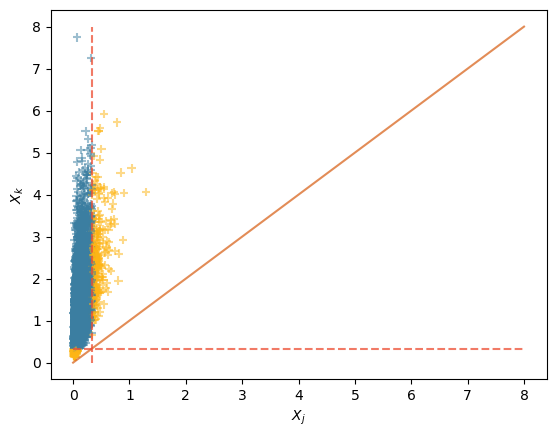

In [5]:
fig_quantile_CI_demo, ax = plt.subplots()

                                                   
ax.set_xlabel(r'$X_j$')
ax.set_ylabel(r'$X_k$')

col = np.where((CI[:,0]<=med_Y) & (CI[:,1]>=med_Y),'#3B7EA1','#FDB515')

ax.scatter(CI[:,0], CI[:,1],color = col, alpha = 0.5, marker = '+')

plt.plot((0, 8), (0, 8), color='#D9661F', alpha = 0.75)
plt.plot((med_Y, med_Y), (0, 8), color='#ED4E33', alpha = 0.75, linestyle='dashed')
plt.plot((0, 8), (med_Y, med_Y), color='#ED4E33', alpha = 0.75, linestyle='dashed')


### Question 3
Study the block of code below. Add comments to the code and describe what it does in this markdown box. Be sure to interpret the printed output.

In [6]:
SE_hat         = ((N*(CI[:,1] - CI[:,0])**2)/(4*z_crit**2))**(1/2)

COV_Wald       = (med_Y_hat - z_crit*SE_hat/(N**(1/2))<=med_Y)*(med_Y_hat + z_crit*SE_hat/(N**(1/2))>=med_Y)
COV_order_stat = (CI[:,0]<=med_Y) & (CI[:,1]>=med_Y)

print(np.mean(COV_order_stat))
print(np.mean(COV_Wald))

0.9536
0.9471


### Question 4
Study the block of code below. Add comments to the code and describe what it does in this markdown box. Describe and discuss the histogram plotted below. Are you more surprised about the results introduced in Question 3 above after considering this plot?

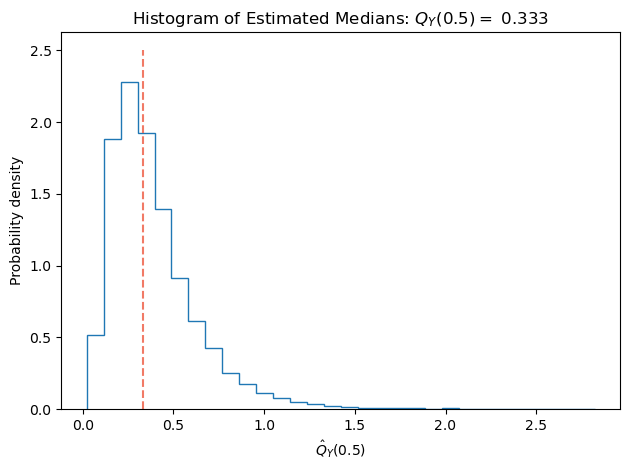

In [7]:
fig_med_Y_hat_hist, ax = plt.subplots()

n, bins, patches = ax.hist(med_Y_hat, bins = 30, density = True, histtype='step', align='mid')


ax.plot((med_Y, med_Y), (0, 2.5), color='#ED4E33', alpha = 0.75, linestyle='dashed')
ax.set_xlabel(r'$\hat{Q}_{Y}\left(0.5\right)$')
ax.set_ylabel('Probability density')
ax.set_title('Histogram of Estimated Medians: '
             r'$Q_Y\left(0.5\right)=$' + f' {med_Y:.3f}')

# Tweak spacing to prevent clipping of ylabel
fig_med_Y_hat_hist.tight_layout()
plt.show()

## Part 2: An initial look at the distribution of Brazilian earnings   
We will now turn out attention to the PNAD data.

### Question 5
Study the block of code below. Add comments to the code and describe what it does in this markdown box. Inspect the contents of the _results_ dataframe. Why do the values of 'lower_CI' and 'upper_CI' sometimes coincide? What assumption is being violated? Can you construct a standard error estimate for 'Q_hat' in such cases? Why or why not? Briefly comment on the plot.

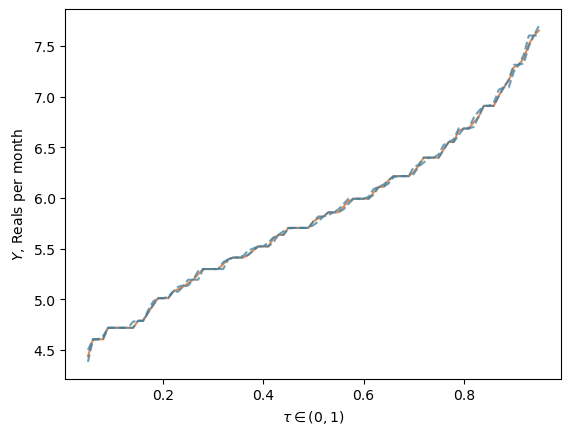

In [8]:
Y      = np.log(sample['MONTHLY_EARNINGS'])
N      = len(Y)                                      
alpha  = 0.05
z_crit = sp.stats.norm(loc=0, scale=1).ppf(1-alpha/2)
X      = np.sort(Y) 

results = {'tau' : [], 'Q_hat': [],'lower_CI' : [], 'upper_CI' : []}

for tau in np.arange(0.05,0.96,0.01):
    l      = ((N*tau*(1-tau))**(1/2))*z_crit
    j      = int(np.floor(N*tau - l))
    k      = int(np.ceil(N*tau + l))
    results['tau'].append(tau)
    results['Q_hat'].append(np.quantile(X, tau))
    results['lower_CI'].append(X[j])
    results['upper_CI'].append(X[k])

    
results = pd.DataFrame.from_dict(results)    

fig_quantile_brazil_earns, ax = plt.subplots()
                                                   
ax.set_xlabel(r'$\tau \in (0,1)$')
ax.set_ylabel(r'$Y$, Reals per month')

plt.plot(results['tau'], results['Q_hat'], color='#D9661F', alpha = 0.75)
plt.plot(results['tau'], results['lower_CI'], color='#3B7EA1', alpha = 0.75, linestyle='dashed')
plt.plot(results['tau'], results['upper_CI'], color='#3B7EA1', alpha = 0.75, linestyle='dashed')

### Question 6

This question compromises the bulk of the problem set. Most of the code you will need to complete this problem set is can be adapted form snippets already given above and/or from earlier problem sets. A small starter snippet of code is provided below to help you get started with parts (d) to (f).

  a. Compute the least squares fit of $\ln(MONTHLY_EARNINGS)$ onto a constant YRSSCH, AgeInDays, and AgeInDays squared

  b. Create a dummy variable for each of the 16 possible schooling levels. Compute the least squares fit of $\ln(MONTHLY_EARNINGS)$ onto each of the 16 dummy variables, AgeInDays, and AgeInDays squared (exclude a constant from this regression).

  c. Plot the regression fits in [a] and [b] on the same figure holding AgeInDays fixed at 40, but varying YRSSCH.

  d. Consider the following $L=9$ age ranges: $\left[20,25\right)$, $\left[25,30\right)$, $\left[30,35\right)$, $\left[35,40\right)$, $\left[40,45\right)$, $\left[45,50\right)$, $\left[50,55\right)$, $\left[55,60\right]$, $\left[60,65\right)$. Let $K=16$ be the number of distinct schooling values (i.e., $0,1,\ldots,15). For each of the $K\times L$=9\times16=144$ years of schooling and age range combinations _with at least 30 observations_ in the dataset estimate the 10th, 25th, 50th, 75th and 90th quantiles of the distribution of log earnings. For each conditional quantile construct a confidence interval using order statistics as described in lecture. Using this confidence interval also construct a standard error estimate. 

  e. Inspect your standard error estimates. Are any of them are zero. Why? Inspect the distribution of MONTHLY_EARNINGS. Is MONTHLY_EARNINGS a continuously-valued random variable? Relate what you find to the phenomena of standard error estimates of zero.

  f. Assume that, for the five estimated quantiles, the conditional quantile function of the logarithm of monthly earnings given schooling and age is a linear function of YRSSCH, AgeInDays, and AgeInDays squared (you may use the mid-point of each of the age ranges as your measure of “age”). Estimate the parameters indexing each of the five conditional quantile functions by minimum distance. You should exclude all cells with less that 30 observations and/or where the estimated standard error is zero. How does the coefficient on schooling vary with the quantile under consideration? How does it compare to that computed in part (b) above?

  g. Summarize, in words, your analysis. How do earnings vary with education in Brazil? [5 to 8 paragraphs]

  h. (**Extra Credit -- 3 homework points**) Repeat your analysis in part (f) for all “centiles” 5,6,7....,94,95. Plot “centile” on the x-axis and the corresponding coefficient on schooling on the y-axis. Also plot the corresponding point-wise 95 percent confidence band. Comment on your graph.

In [70]:
YrsSchLevels = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
AgeLevels   = [20, 25, 30, 35, 40, 45, 50, 55, 60]

n = N

alpha  = 0.1
z_crit = sp.stats.norm(loc=0, scale=1).ppf(1-alpha/2)

results = {'tau' : [], 'Q_hat': [], 'wgt' : [], 'Constant' : [], 'YrsSch' : [], 'Age' : [], 'AgeSq' : [], 'N' : []}

for yrssch in YrsSchLevels:
    for age in AgeLevels:
        Y = np.log(sample['MONTHLY_EARNINGS'].loc[(sample['YRSSCH'] == yrssch) & (sample['AgeInDays'] >= age) & (sample['AgeInDays'] < age + 5)])
        X = np.sort(Y) 
        N = len(Y)
        for tau in [0.1, 0.25, 0.50, 0.75, 0.90]:
            l      = ((N*tau*(1-tau))**(1/2))*z_crit
            j      = int(np.floor(N*tau - l)) - 1
            k      = int(np.ceil(N*tau + l)) - 1
        
            results['tau'].append(tau)
            results['Q_hat'].append(np.quantile(X, tau))
            
            if N >= 30:
                results['wgt'].append((n*((X[k] - X[j])**2) /  (4*(z_crit**2)) )**(-1) )
            else:
                results['wgt'].append(-9)
            
            results['Constant'].append(1)
            results['YrsSch'].append(yrssch)
            results['Age'].append((2*age+5)/2)
            results['AgeSq'].append(((2*age+5)/2)**2)
            results['N'].append(N)
        

/var/folders/c8/yk_10hk9567585dxl5c83xqc000148/T/ipykernel_30520/211701556.py:25: RuntimeWarning: divide by zero encountered in scalar power
  results['wgt'].append((n*((X[k] - X[j])**2) /  (4*(z_crit**2)) )**(-1) )


In [71]:
results = pd.DataFrame.from_dict(results)  
results

,tau,Q_hat,wgt,Constant,YrsSch,Age,AgeSq,N
0,0.10,3.912023,3.191819,1,0,22.5,506.25,758
1,0.25,4.442651,2.130815,1,0,22.5,506.25,758
2,0.50,4.787492,22.289786,1,0,22.5,506.25,758
3,0.75,5.298317,inf,1,0,22.5,506.25,758
4,0.90,5.703782,5.181195,1,0,22.5,506.25,758
...,...,...,...,...,...,...,...,...
715,0.10,6.696390,0.126371,1,15,62.5,3906.25,102
716,0.25,7.090077,0.645368,1,15,62.5,3906.25,102
717,0.50,7.696213,0.645368,1,15,62.5,3906.25,102
718,0.75,8.294050,0.406602,1,15,62.5,3906.25,102


In [72]:
from sklearn import linear_model

W = results[['Constant','YrsSch', 'Age', 'AgeSq']].loc[(results['tau'] == 0.1) & (results['N'] >= 30) & np.isfinite(results['wgt'])]
pi_hat = results['Q_hat'].loc[(results['tau'] == 0.1) & (results['N'] >= 30) & np.isfinite(results['wgt'])]
wgts = results['wgt'].loc[(results['tau'] == 0.1) & (results['N'] >= 30) & np.isfinite(results['wgt'])]

iOMEGA = np.diag(wgts)


# Create linear regression object
regr = linear_model.LinearRegression(fit_intercept=False)

# Fir the calorie demand model
regr.fit(W, pi_hat, sample_weight=wgts)

print("Coefficients: \n", regr.coef_)
W = W.to_numpy()

Coefficients: 
 [ 2.36905140e+00  1.13217655e-01  9.90446342e-02 -1.16010693e-03]


In [73]:
np.shape(W.T)
#np.shape(iOMEGA)

(4, 117)

In [74]:
std_errs = np.diag(np.linalg.inv(W.T @ iOMEGA @ W)/n)**(1/2)

In [75]:
std_errs

array([6.73822339e-02, 1.37024956e-03, 3.67179631e-03, 4.60171050e-05])